# Additional comments for the main paper

**Yueying Sun and Johannes Ruf**

July 2024

This Jupyter notebook serves as a supplementary document to our main research paper, providing additional insights and analyses that enhance the comprehensiveness of our study. Although these elements are not included in the primary manuscript, they play a crucial role in supporting and validating our research findings. Specifically, this notebook covers the following key components:

- **Simulation of mandate models**: In the "Introduction of stochasticity" section of main paper, we use binomial model to model the bond capitalisation path. In this notebook, we additionally provide a simulation where the bond capitalisation path is based on the geometric Brownian motion (GBM) model. By using a more complex model, we aim to illustrate how different types of mandates influence mandate-implied stock capitalisation volatilities.

- **Data comparison:** In the main paper, we use bond and equity data from the Flow of Funds to conduct empirical anaysis. Here, we compare the bond and equity data from the Flow of Funds with corresponding data from other datasets to ensure robustness and validity.  

- **Empirical analysis on the constant mandate:** In the main paper, we evaluate the efficacy of a momentum-type mandate model. In this notebook, we further use the Flow of Funds data to backtest our constant mandate. The constant mandate can serve as a benchmark for the momentum-type mandate, helping to highlight the specific advantages or disadvantages of each approach.

# Simulation of mandate models

We simulate the stock value path given that the bond value path follows a geometric Brownian motion. 

First, we import all modules that we need and seed the random number generator. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
rng = np.random.default_rng(seed=123456)

## Bond value path

Let $dt = T/n$. Fix a set of points $0 < t_1 < \ldots < t_n \leq T $, where $t_i = dt * i$. Fix $B_0$ as a constant and for $i = \{1,2,3,...,n\}$, define
$$B_{i} = B_{i-1} e^{\left(r - \frac{1}{2}  σ^2 \right) dt + σ \sqrt{dt} Z_i},$$
where $(Z_i, \ldots, Z_n)$ are i.i.d standard normally distributed random variables.

In [3]:
def simulate_bond_gbm(rng, σ, T, r, n, B0):
    dt = T/ n
    paths = np.zeros(n+1)
    paths[0] = B0
    for i in range(n):
        z = rng.standard_normal(size=1)
        paths[i+1] = paths[i] * np.exp((r - 0.5 * σ ** 2) * dt + σ * np.sqrt(dt) * z)
    return paths

## Stock value path

Now we compute the mandate-implied stock value based on three different mandates. We derive the mandate-implied value $(P_t)_{t \in [0,T]}$ for a specific bond value path $(B_t)_{t \in [0,T]}$.

In each case, we assume $\mathfrak{m}^{(j)}_0 \ (j = 1, 2, 3)$ is constant with value $0.65$ and correspondingly, the mandate-implied value $P^j_0$ satisfies
$$P^j_0 = \frac{\mathfrak{m}^{(j)}_0(1)}{1 - \mathfrak{m}^{(j)}_0(1)} B_0 \ (j = 1, 2, 3).$$

### Case 1

First we consider a constant mandate. Let $\mathfrak{m}^{(1)}_{t_i} = 0.65$ for each $i \in \{1,2, \ldots, n\}$ and the mandate-implied value function satisfies
$$P^{(1)}_i = \frac{\mathfrak{m}^{(1)}_i(1)}{1 - \mathfrak{m}^{(1)}_i(1)} B_i.$$


In [4]:
def compute_stock_m1(B, T, n, P0, m=0.65):
    dt = T / n
    
    P = np.zeros(n+1)
    P[0] = P0
    
    for i in range(n):
        P[i+1] = m / (1 - m) * B[i+1]
        
    return P

### Case 2

We now consider a mandate that yields higher volatility in stock than bond. We assume that the mandate-implied value is iteratively given as
$$P^{(2)}_i = \left(\frac{B_{i}}{B_{i-1}} \right)^2 P^{(2)}_{i-1}, \quad i \in \{1,2, \ldots, n\}.$$

In [5]:
def compute_stock_m2(B, T, n, P0):
    dt = T / n
    
    P = np.zeros(n+1)
    P[0] = P0
    
    for i in range(n):
        P[i+1] = P[i] * (B[i+1] / B[i])**2
        
    return P

### Case 3

We at last consider a mandate that yields lower volatility in stock than bond.  We assume that the mandate-implied value is iteratively given as
$$P^{(3)}_i = \sqrt{\frac{B_{i}}{B_{i-1}}} P^{(3)}_{i-1}, \quad i \in \{1,2, \ldots, n\}.$$

In [6]:
def compute_stock_m3(B, T, n, P0):
    dt = T / n
    
    P = np.zeros(n+1)
    P[0] = P0
    
    for i in range(n):
        P[i+1] = P[i] * (B[i+1] / B[i]) ** 0.5
         
    return P

## Simulation
We first give the following parameters.

In [7]:
T = 1
n = 250 #how many periods of time

σ = 0.2
r = 0.05


B0 = 1
m0 = 0.65 #initial manadate
P0 = B0 * m0 / (1 - m0)

The below cell runs one simulation for each of the three mandate-implied stock values above.

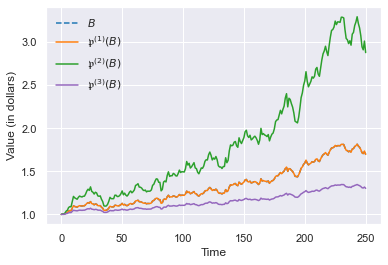

In [8]:
bond_path = simulate_bond_gbm(rng, σ, T, r, n, B0)
bond_path_norm = bond_path/B0

stock_path1 = compute_stock_m1(bond_path, T, n, P0)
stock_path_norm1 = stock_path1/P0

stock_path2 = compute_stock_m2(bond_path, T, n, P0)
stock_path_norm2 = stock_path2/P0

stock_path3 = compute_stock_m3(bond_path, T, n, P0)
stock_path_norm3 = stock_path3/P0

_, ax = plt.subplots()
ax.plot(bond_path_norm, linestyle = 'dashed', color = '#1f77b4');
ax.plot(stock_path_norm1,  color = '#ff7f0e');#con
ax.plot(stock_path_norm2,  color = '#2ca02c');#more
ax.plot(stock_path_norm3,  color = '#9467bd');#less
ax.set_ylabel('Value (in dollars)')
ax.set_xlabel('Time')
plt.legend(['$B$','$\mathfrak{p}^{(1)}(B)$','$\mathfrak{p}^{(2)}(B)$','$\mathfrak{p}^{(3)}(B)$'], frameon=False);
#plt.savefig('gbm_simuin1.png',bbox_inches='tight');

The below cell computes each return of the bond and the three mandate-implied stock values above. 

In [9]:
bondreturn = np.diff(bond_path_norm) / bond_path_norm[:-1]
stockreturn1 = np.diff(stock_path_norm1) / stock_path_norm1[:-1]
stockreturn2 = np.diff(stock_path_norm2) / stock_path_norm2[:-1]
stockreturn3 = np.diff(stock_path_norm3) / stock_path_norm3[:-1]

Next we compute the annualised standard deviation of the above returns.

In [10]:
stockreturn1.std(ddof = 1) * np.sqrt(250)

0.19428109557388978

In [11]:
stockreturn2.std(ddof = 1) * np.sqrt(250)

0.3893739265747887

In [12]:
stockreturn3.std(ddof = 1) * np.sqrt(250)

0.09704794422718471

The results comply with the volatility implications discussed in Example 5.11 and Example 5.17 of the main paper, further validating our theoretical results.

An interesting observation arises when comparing the binomial model given in the main paper and the geometric Bownian motion model given above. By setting the parameters of the binomial model to be consistent with those of the geometric Brownian motion model as follows,

$$u = e^{\sigma \sqrt{\Delta t}}, d=\frac{1}{u},$$ 

with the risk-neutral probability

$$p = \frac{e^{r \Delta t} - d}{u - d},$$ 

we find that the mandate-implied stock returns from both models are very similar. This result highlights an important insight: although the binomial model and the geometric Bownian motion model generate different paths due to their discrete versus continuous nature, their calibrated parameters align in such a way that the long-term returns are comparable. 

# Datasets comparison

We compare the equity and bond datasets from different data sources.


- For the bond data: 
    - Federal Reserve (Z.1 Statistical Release): Data is quarterly recorded and we denote it as FoF in this notebook. We use Table L210 US Treasury and Table L213 Corporate & Foreign Bonds. To obtain the total bond capitalization, we sum the values from these two tables. (link: https://www.federalreserve.gov/datadownload/Choose.aspx?rel=z1)

    - U.S. Treasury Monthly Statement of the Public Debt: Data is on monthly basis, recording two main types of securities: marketable securities and nonmarketable securities. In this notebook, we denote this dataset as MSPD. (link: https://fiscaldata.treasury.gov/datasets/monthly-statement-public-debt/summary-of-treasury-securities-outstanding) We compare the marketable and nonmarketable securities from the MSPD to the corresponding security types in Table L210 US Treasury from the Federal Reserve's Z.1 Statistical Release.


- For the equity data: 
    - Federal Reserve (Z.1 Statistical Release): We use Table L223 Corporate Equities.
    - CRSP: We access the monthly stock security data through WDRS.


## Preparation

First, we import all modules that we need and initialize the datapath, where we put the data downloaded from FoF, M2SL and MSPD. 

In [13]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn
seaborn.set()

datapath = './data/'

### To begin with, we import data from FoF. 

In particular, we use 'xml.etree.ElementTree' to get access to the data in xml file, downloaded from FoF. We choose to access the data through their series number. 

In [14]:
import xml.etree.ElementTree as ET

Series identifiers:

- Table L210 US Treasury

    - All sectors; Treasury securities; asset: FL893061105.Q

    - Rest of the world; Treasury securities; asset: LM263061105.Q
    
    - Federal government; marketable Treasury securities; liability: FL313161205.Q
    
    - Federal government; nonmarketable Treasury securities; liability: FL313161305.Q

- Table L213 Corporate & Foreign Bonds

    - All sectors; corporate and foreign bonds; asset: FL893063005.Q

    - Rest of the world; corporate bonds; asset: LM263063005.Q

- Table L223 Corporate Equities
    
    - All sectors; corporate equities; asset: LM893064105.Q

    - Rest of the world; U.S. corporate equities; asset: LM263064105.Q

In [15]:
SERIES_NAME_LIST = ['FL893061105.Q', 'LM263061105.Q', 'FL893063005.Q', 'LM263063005.Q', 'LM893064105.Q', 'LM263064105.Q','FL313161205.Q', 'FL313161305.Q']

In [16]:
tree = ET.parse(datapath + './FRB_z1/Z1_data.xml') 
root = tree.getroot()

In [17]:
namespace = {
    'kf': 'http://www.federalreserve.gov/structure/compact/Z1_Z1',
    'frb': 'http://www.federalreserve.gov/structure/compact/common'
}

data_lists = []
time_lists = []

for name in SERIES_NAME_LIST:
    new_list_data = []
    new_list_time = []
    for series in root.findall('.//kf:Series', namespaces=namespace):
        series_name = series.get('SERIES_NAME')
        if series_name == name:
            observations = series.findall('.//frb:Obs', namespaces=namespace)
            
            # Extract OBS_VALUE and TIME_PERIOD and store them in arrays
            for obs in observations:
                obs_value = obs.get('OBS_VALUE')
                time_period = obs.get('TIME_PERIOD')
                new_list_data.append(obs_value)
                new_list_time.append(time_period)
    data_lists.append(new_list_data)
    time_lists.append(new_list_time)

In [18]:
# Checking that all the time lists are the same"
all_identical = True
for list_cand in time_lists:
    all_identical &= (list_cand == time_lists[0])
    
assert all_identical

In [19]:
df_FoF = pd.DataFrame(map(list, zip(*data_lists)), index=pd.to_datetime(time_lists[0])).apply(pd.to_numeric)
df_FoF.columns = ['UST_All', 'UST_RoW', 'CB_All', 'CB_RoW', 'CE_All', 'CE_RoW','UST_M', 'UST_NM'] 
df_FoF = df_FoF.mask(df_FoF < 0).ffill()    #as before 1960, there are only annual data and others are coded as negative numbers

In [20]:
df_FoF['UST'] = df_FoF['UST_All'] - df_FoF['UST_RoW']
df_FoF['CB'] = df_FoF['CB_All'] - df_FoF['CB_RoW']

df_FoF['equity'] = df_FoF['CE_All'] - df_FoF['CE_RoW']
df_FoF['bond'] = df_FoF['UST'] + df_FoF['CB']

df_FoF = df_FoF.div(1_000_000).copy() # to turn millions into trillions

### Now we load US treasury data from US Fiscal data.

In [21]:
df_MSPD = pd.read_csv(datapath + 'MSPD_SumSecty_20010131_20230430.csv')

In [22]:
df_MSPD['Record Date'] = pd.to_datetime(df_MSPD['Record Date'])
df_MSPD.sort_values(by='Record Date', inplace = True)
df_MSPD = df_MSPD.set_index('Record Date')

### Now we access the stock security data through WRDS

Here, we import both the common share data and the all share data from CRSP.

In [23]:
import wrds

In [24]:
wrds_login = 'rennie97'
db = wrds.Connection(wrds_username=wrds_login)

Loading library list...
Done


In [25]:
%%time

df_CRSP = db.raw_sql("""SELECT mthcaldt, 
                SUM(CASE WHEN sharetype = 'NS' AND securitysubtype = 'COM' 
                AND issuertype IN ('ACOR','CORP') AND usincflg = 'Y' 
                THEN mthcap ELSE 0 END) AS total_common_mthcap,
                SUM(mthcap) AS total_all_mthcap
                FROM crsp.StkMthSecurityData 
                WHERE mthcaldt BETWEEN '1950-01-01' AND '2023-12-31'
                GROUP BY mthcaldt
                """, date_cols='mthcaldt')

CPU times: user 24.5 ms, sys: 4.61 ms, total: 29.1 ms
Wall time: 3.31 s


In [26]:
#concatinate a line as the monthly mktcap means the mktcap one month ahead
tmp = pd.DataFrame(np.nan, index=[pd.to_datetime('2000-12-31')], columns = df_CRSP.columns)
df_CRSP = pd.concat([tmp,df_CRSP])

#move everything one row ahead and remove the last row
df_CRSP = df_CRSP.shift(-1).iloc[:-1]

In [27]:
df_CRSP['mthcaldt'] = pd.to_datetime(df_CRSP['mthcaldt'])
df_CRSP.set_index('mthcaldt', inplace = True)
df_CRSP = df_CRSP.div(1_000_000_000).copy() #to turn thousands into trillions

## Comparison

Below we plot the datasets and compare them.

### Bond data comparison: US treasury data sourced from FoF and MSPD. 

Here, we compare the marketable security and the nonmarketable security respectively.

- Marketable securities

In [28]:
df_MSPD_M = df_MSPD.loc[df_MSPD['Security Type Description'] == 'Total Marketable']['Total Public Debt Outstanding (in Millions)']
df_MSPD_M = df_MSPD_M.div(1_000_000).copy() #to turn billions into trillions

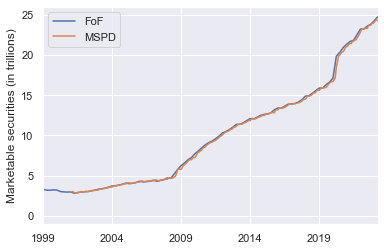

In [29]:
df_FoF['UST_M'].plot()
df_MSPD_M.plot()
plt.xlim(pd.Timestamp('1999-01-01'),)
plt.legend(['FoF','MSPD']);
plt.xlabel('')
plt.ylabel('Marketable securities (in trillions)');
#plt.savefig('UST_marketable.png')

- Nonmarketable securities

In [30]:
df_MSPD_NM = df_MSPD.loc[df_MSPD['Security Type Description'] == 'Total Nonmarketable']['Total Public Debt Outstanding (in Millions)']
df_MSPD_NM = df_MSPD_NM.div(1_000_000).copy() #to turn billions into trillions

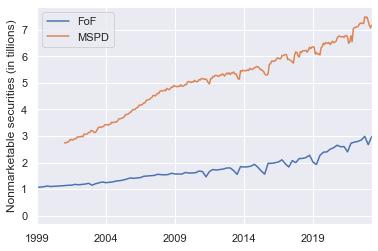

In [31]:
df_FoF['UST_NM'].plot()
df_MSPD_NM.plot()
plt.xlim(pd.Timestamp('1999-01-01'),)
plt.legend(['FoF','MSPD']);
plt.xlabel('')
plt.ylabel('Nonmarketable securities (in tillions)');
#plt.savefig('UST_nonmarketable.png')

- Total securities

In [32]:
df_MSPD_ALL = df_MSPD.loc[df_MSPD['Security Type Description'] == 'Total Public Debt Outstanding']['Total Public Debt Outstanding (in Millions)']
df_MSPD_ALL = df_MSPD_ALL.div(1_000_000).copy() #to turn billions into trillions

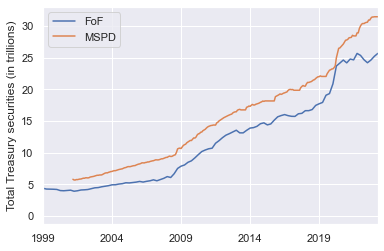

In [33]:
df_FoF['UST_All'].plot()
df_MSPD_ALL.plot()
plt.xlim(pd.Timestamp('1999-01-01'),)
plt.legend(['FoF','MSPD']);
plt.xlabel('')
plt.ylabel('Total Treasury securities (in trillions)');
#plt.savefig('UST_total.png')

For marketable securities, the datasets from FoF and MSPD are largely consistent, with minor rounding differences. However, for non-marketable securities, there is a significant discrepancy between the two datasets. Upon reviewing the non-marketable securities data, we found that the figures for savings securities and State and Local Government Series (SLGS) are roughly the same, with minor rounding differences. However, the remaining categories do not match well. This discrepancy can be explained by the following factors:

- Categorization Differences: FoF may use different categorization methods for non-marketable securities compared to the MSPD. This can lead to differences in which types of securities are included or excluded in each dataset.

- Broader Range in MSPD: The MSPD data may encompass a broader range of non-marketable securities. This includes securities held by government trust funds, retirement funds, and other specific special funds that are not classified the same way in the FoF dataset. 

Consequently, the MSPD may report higher totals for non-marketable securities due to these additional inclusions.

### Equity data comparison: stock capitalisation scourced from FoF and CRSP. 

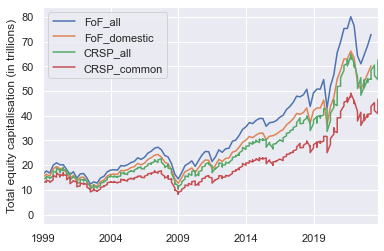

In [34]:
df_FoF['CE_All'].plot();
df_FoF['equity'].plot();
df_CRSP['total_all_mthcap'].plot();
df_CRSP['total_common_mthcap'].plot();
plt.xlim(pd.Timestamp('1999-01-01'))
plt.legend(['FoF_all', 'FoF_domestic','CRSP_all', 'CRSP_common']);
plt.xlabel('')
plt.ylabel('Total equity capitalisation (in trillions)');
#plt.savefig('Equity_comparison.png')

All four paths exhibit similar trends, with the following hierarchy in capitalisation levels: FoF corporate equities held by all sectors (including the foreign investros), FoF corporate equities held by the domestic investors (excluding foreign investros), CRSP stock market capitalisation of all shares, and CRSP stock market capitalisation of common shares. In particular, the CRSP all shares data and the FoF corporate equities held by domestic investors (excluding foreign investors) exhibit very similar values. 

While CRSP and FoF datasets are closely aligned, there are some discrepancies due to their different focuses and methodologies. The CRSP dataset focuses on detailed stock market data for individual securities listed on major U.S. exchanges (NYSE, NASDAQ, AMEX), ensuring high accuracy by compiling data directly from stock exchanges. Conversely, the FoF dataset aggregates the total market value of stocks held by various sectors, including foreign investors. This includes both publicly traded and private company shares, and other forms of corporate ownership, from a variety of sources, which may include approximations and broader categorisations. This broader scope and diverse data sources can introduce variations in the reported figures.

# Empirical analysis on constant mandate model

We use Flow of Funds data to backtest our mandate model. In our analysis, we assume that the bond value is the sum of US Treasury bonds and the corporate bonds, while the equity value is the corporate equity. These values are stored in the 'bond' and 'equity' colummns, respectively, in the dataframe 'df_FoF'.

We first initialise a dataframe for backtesting. 

In [35]:
df = df_FoF[['equity' ,'bond']].copy()

### Mandate model


Fix $t \in \mathbb{N}$. Suppose the mandate-implied return function $f_t: (0, \infty) \rightarrow (0,\infty)$ satisfies

$$f_t = \frac{m}{1-m} \frac{B_{t-1}}{P_{t-1}} \mathrm{id},$$

where $P$ denotes the stock value, $B$ denotes the bond value and $m \in (0,1)$. Then the mandate function is a constant function, with $m_t=  m \in (0,1)$.



Let $i$ denote the $i$th sample $(i = 1,...., n)$, $y_i$ denote the stock return (actually return + 1) and $x_i$ denote the bond return (actually return + 1). Our **GOAL** is to find the **$\mu$** to minimise our loss function

$$L(\mu) = \sum_{i=1}^{n}(y_i - \mu z_i)^2,$$

where $$\mu = \frac{m}{1-m}, \quad z_i = \frac{B_{i-1}}{P_{i-1}} x_i.$$

We use the 'minimize' function of the module 'scipy.optimize' to obtain the optimal parameter $\mu^*$, which yields the optimal $m^*$ by 

$$m^* = \frac{\mu^*}{1+\mu^*}.$$

We first import the 'minimize' function and define the loss function in the cell below, which later is used in the 'minimize' function.

In [36]:
from scipy.optimize import minimize

In [37]:
def loss_function(params, x, y_target):
    μ = params
    y_predicted = μ * x 
    return sum((y_predicted - y_target)**2)

In the following cell, we prepare the data used to backtest, specifically, the bond return $x_i$, the stock return $y_i$ and $z_i =  \frac{B_{i-1}}{P_{i-1}} x_i$.

In [38]:
df['equity_ret'] = df['equity']/df['equity'].shift(1) #return+1
df['bond_ret'] = df['bond']/df['bond'].shift(1)

df['boverp'] = df['bond']/df['equity']
df['z'] = df['boverp'].shift(1) * df['bond_ret']

Now we approximate the optimal parameter $m^*$. We use different rolling window length $l = 2, 3, 4$ years. This means in the notation above, we have $n = 4l$ (as we have quarterly data) and for every $n$ data, we compute one $m$. We use the 'minimize' function from the 'scipy.optimize' module to find the optimal $m^*$.

In [39]:
nlengths = [8, 12, 16]
colors = ['#ff7f0e','#2ca02c','#9467bd'] #orange, green, purple

In [40]:
columns_m = ['m_' + str(n) for n in nlengths]
columns_m_forecast = ['m_forecast_' + str(n) for n in nlengths]
columns_m_error = ['m_error_' + str(n) for n in nlengths]

plot_labels = (['$l = ' + str(int(n/4)) + '$' for n in nlengths] if all([(n/4).is_integer() for n in nlengths]) 
               else ['$l = ' + str(n/4) + '$' for n in nlengths])

for a in columns_m:
    df[a] = np.nan

In [41]:
for (n, a) in zip(nlengths, columns_m):
    for i in range(len(df) - n + 1):
        x = df.iloc[i:i+n]['z']
        y = df.iloc[i:i+n]['equity_ret']
        result = minimize(loss_function, 1, args=(x, y)) #choose initial value as 1 and we obtain the optimal μ
        df[a].iloc[n - 1 + i] = (result.x) / (1+ result.x) #here we obtain the optimal m

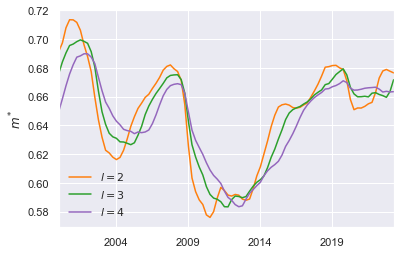

In [42]:
df[columns_m].loc['2000':].plot(color=colors)
plt.ylabel('$m^*$')
plt.legend(plot_labels, frameon=False);#as the data is seasonal
#plt.savefig('m3_in1.png',bbox_inches='tight');

Under different window lengths, we plot the model-implied stock value and the model prediction error. The model prediction error equals the difference between the equity value observation and the model-implied equity value.

In [43]:
for (f, a) in zip(columns_m_forecast, columns_m):
    df[f] = df['equity'].shift(1) * (df[a].shift(1)/(1-df[a].shift(1))) * df['z']    

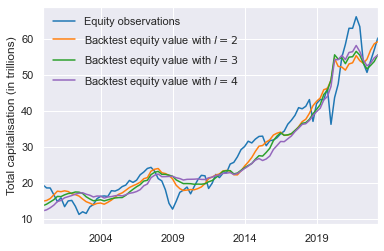

In [44]:
df[['equity'] + columns_m_forecast].loc['2000':].plot(color=['#1f77b4'] + colors)
plt.legend(['Equity observations'] + ['Backtest equity value with ' + p for p in plot_labels], frameon=False);
plt.ylabel('Total capitalisation (in trillions)');
#plt.savefig('backtest3_in1.png',bbox_inches='tight');

In [45]:
df['error_equity_constant'] = df['equity'] - df['equity'].shift(1)

for (e, f) in zip(columns_m_error, columns_m_forecast):
    df[e] = df['equity'] - df[f]

Text(0, 0.5, 'Model prediction error (in trillions)')

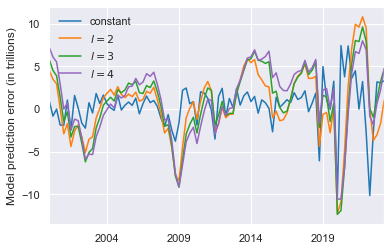

In [46]:
df[['error_equity_constant'] + columns_m_error].loc['2000':].plot(color=['#1f77b4'] + colors)

plt.legend(['constant'] + plot_labels, frameon=False)
plt.ylabel('Model prediction error (in trillions)')
#plt.savefig('backtesterror.png',bbox_inches='tight');

The backtest above uses the data starting from $2000$. Since the starting date might potentially affect the outcomes of the backtest, we conduct following backtests starting from 1990, 1995, 2000, 2005 and 2010, respectively. 

In [47]:
startyears = ['1990', '1995', '2000', '2005']

In [48]:
df_error = pd.DataFrame()

for t in startyears:
    error_tmp = pd.DataFrame([(df['equity'] - df['equity'].shift(1)).loc[t:].abs().mean()])
    error_tmp = pd.concat([error_tmp, df[columns_m_error].loc[t:].abs().mean()])
    df_error = pd.concat([df_error, error_tmp], axis=1)

df_error.index = ['Constant error'] + plot_labels
df_error.columns = pd.MultiIndex.from_product([['Starting year'], startyears])

In [49]:
error_style = (df_error.style.format('{:.2f}')
            .format_index("\\textbf{{{}}}", axis=1)
            .format_index("\\textbf{{\\boldmath{{{}}}}}", axis=0)
              )
print(error_style.to_latex(position="h", hrules=True, multicol_align = "l",
                           caption="Absolute prediction error comparison (in trillions).", 
                           label = "m_error_compare", position_float = "centering"))

\begin{table}[h]
\centering
\caption{Absolute prediction error comparison (in trillions).}
\label{m_error_compare}
\begin{tabular}{lrrrr}
\toprule
 & \multicolumn{4}{l}{\textbf{Starting year}} \\
 & \textbf{1990} & \textbf{1995} & \textbf{2000} & \textbf{2005} \\
\midrule
\textbf{\boldmath{Constant error}} & 1.45 & 1.67 & 1.83 & 2.03 \\
\textbf{\boldmath{$l = 2$}} & 2.46 & 2.85 & 3.04 & 3.18 \\
\textbf{\boldmath{$l = 3$}} & 2.74 & 3.16 & 3.26 & 3.42 \\
\textbf{\boldmath{$l = 4$}} & 2.99 & 3.45 & 3.48 & 3.67 \\
\bottomrule
\end{tabular}
\end{table}



### Reverse model

Now we consider the model reversely (the dual model). Instead of using the bond data as model input, we now use the equity data as the model input. 

In [50]:
df['poverb'] = df['equity']/df['bond']
df['z_tilde'] = df['poverb'].shift(1) * df['equity_ret']

In [51]:
columns_m_tilde = ['m_tilde_' + str(n) for n in nlengths]
columns_m_tilde_forecast = ['forecast_m_tilde_' + str(n) for n in nlengths]
columns_m_tilde_error = ['error_m_tilde_' + str(n) for n in nlengths]

for a in columns_m_tilde:
    df[a] = np.nan

In [52]:
for (n, a) in zip(nlengths, columns_m_tilde):
    for i in range(len(df) - n + 1):
        x = df.iloc[i:i+n]['z_tilde']
        y = df.iloc[i:i+n]['bond_ret']
        result = minimize(loss_function, 1, args=(x, y)) #choose initial value as 1
        df[a].iloc[n - 1 + i] = (result.x) / (1+ result.x) 

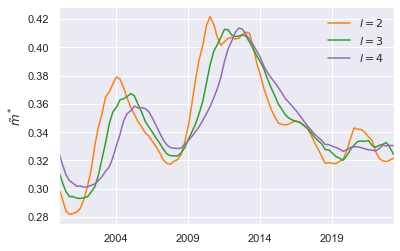

In [53]:
df[columns_m_tilde].loc['2000':].plot(color=colors)
plt.ylabel('$\\tilde{m}^*$')
plt.legend(plot_labels, frameon=False);
#plt.savefig('mt3_in1.png',bbox_inches='tight');

In [54]:
for (f, a) in zip(columns_m_tilde_forecast, columns_m_tilde):
    df[f] = df['bond'].shift(1) * (df[a].shift(1)/(1-df[a].shift(1))) * df['z_tilde']

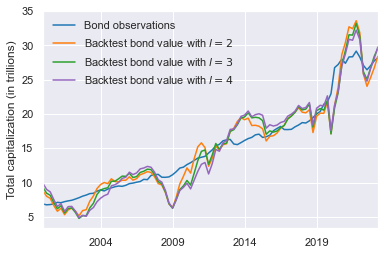

In [55]:
df[['bond'] + columns_m_tilde_forecast].loc['2000':].plot(color=['#1f77b4'] + colors)
plt.legend(['Bond observations'] + ['Backtest bond value with ' + p for p in plot_labels], frameon=False);
plt.ylabel('Total capitalization (in trillions)');
#plt.savefig('backtest_in3_in1.png',bbox_inches='tight');

In [56]:
df['error_bond_constant'] = df['bond'] - df['bond'].shift(1)

for (e, f) in zip(columns_m_tilde_error, columns_m_tilde_forecast):
    df[e] = df['bond'] - df[f]

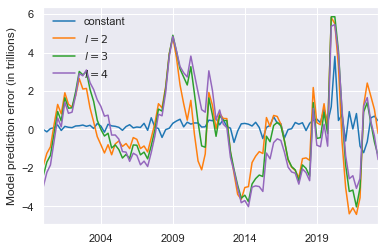

In [57]:
df[['error_bond_constant'] + columns_m_tilde_error].loc['2000':].plot(color=['#1f77b4'] + colors)

plt.legend(['constant'] + plot_labels, frameon=False)
plt.ylabel('Model prediction error (in trillions)');
#plt.savefig('backtesterror_in.png',bbox_inches='tight');

In [58]:
df_error_tilde = pd.DataFrame()

for t in startyears:
    error_tmp = pd.DataFrame([(df['bond'] - df['bond'].shift(1)).loc[t:].abs().mean()])
    error_tmp = pd.concat([error_tmp, df[columns_m_tilde_error].loc[t:].abs().mean()])
    df_error_tilde = pd.concat([df_error_tilde, error_tmp], axis=1)

df_error_tilde.index = ['Constant error'] + plot_labels
df_error_tilde.columns = pd.MultiIndex.from_product([['Starting year'], startyears])

df_error_tilde.round(2)

Starting year                  
                        1990  1995  2000  2005
Constant error          0.27  0.30  0.35  0.41
$l = 2$                 1.33  1.52  1.60  1.69
$l = 3$                 1.47  1.68  1.71  1.81
$l = 4$                 1.65  1.88  1.89  1.98